# Fitting V4 voxels from Alexnet conv3 features

In [1]:
#In this notebook we're going to take an initial stab at fitting the V4 neurons using the alexnet conv3 features

In [2]:
#basic imports
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import pymongo as pm
import numpy as np
import h5py
import scipy as sp
import scipy.stats as stats
import os

from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import RidgeCV, Ridge

In [3]:
# read in the alexnet features
h5f = h5py.File('alexnet/alexnet_conv3_features.h5','r')
train_features = h5f['train'][:] #features for the training images
val_features = h5f['val'][:] #features for the validation images
h5f.close()

In [4]:
train_features.shape

(1750, 14, 14, 384)

In [5]:
# let's bring in the brain data

#read in the mat files
with h5py.File('data/EstimatedResponses.mat','r') as fmri_dataset:
    train_S1 = fmri_dataset['dataTrnS1'][:]
    test_S1 = fmri_dataset['dataValS1'][:]
    roi_S1 = fmri_dataset['roiS1'][:]
    
    train_S2 = fmri_dataset['dataTrnS2'][:]
    test_S2 = fmri_dataset['dataValS2'][:]
    roi_S2 = fmri_dataset['roiS2'][:]
    
    unique_ROIs = np.unique((fmri_dataset['roiS1'])) 

In [6]:
#organize subject 1
S1_train_data_by_ROI = {c: train_S1[:,roi_S1[0,:] == c] 
                       for c in unique_ROIs}
S1_test_data_by_ROI = {c: test_S1[:,roi_S1[0,:] == c] 
                       for c in unique_ROIs}
#organize subject 2
S2_train_data_by_ROI = {c: train_S2[:,roi_S2[0,:] == c] 
                       for c in unique_ROIs}
S2_test_data_by_ROI = {c: test_S2[:,roi_S2[0,:] == c] 
                       for c in unique_ROIs}

In [7]:
S1_train_data_by_ROI.keys()
# remember the one we care about is index 6 for V4

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]

In [8]:
#okay how many voxels are we working with
print(S1_train_data_by_ROI[6.0].shape)
print(S2_train_data_by_ROI[6.0].shape)

(1750, 1550)
(1750, 1022)


In [9]:
#Select only V4 voxels & get rid of any voxels that have NaNs for any training images

#in future versions we may want to replace voxel/image NaNs 
#with the average BOLD response across other images for that voxel
#but got now let's start by just excluding these voxels

#Subject 1
S1_V4 = S1_train_data_by_ROI[6.0].T
x=S1_V4[~np.isnan(S1_V4).any(axis=1)]
S1_V4_train = x.T
print(S1_V4_train.shape)

S1_V4_val = S1_test_data_by_ROI[6.0].T
x=S1_V4_val[~np.isnan(S1_V4).any(axis=1)]
S1_V4_test = x.T
print(S1_V4_test.shape)

sum(sum(np.isnan(S1_V4_test))) #make sure we don't have any NaNs left in the test data

#Subject 2
S2_V4 = S2_train_data_by_ROI[6.0].T
x=S2_V4[~np.isnan(S2_V4).any(axis=1)]
S2_V4_train = x.T
print(S2_V4_train.shape)

S2_V4_val = S2_test_data_by_ROI[6.0].T
x=S2_V4_val[~np.isnan(S2_V4).any(axis=1)]
S2_V4_test = x.T
print(S2_V4_test.shape)

sum(sum(np.isnan(S2_V4_test))) #make sure we don't have any NaNs left in the test data

(1750, 1535)
(120, 1535)
(1750, 1022)
(120, 1022)


0

## Try out regression models with subject 1 data

In [33]:
# define some useful functions - note that everything in this cell is adapted from Yamins lab functions
# (https://github.com/neuroailab/psych253)
def rsquared(v1, v2):
    w, b, r, p, ser = stats.linregress(v1, v2)
    return r**2

def evaluate_regression_results(predicted, actual):
    """computing various useful metrics for regression results
    """
    result = {}
    if actual.ndim > 1: #this is triggered if the prediction is of multiple outputs at once
        result['pearson_array'] = np.array([stats.pearsonr(p, a)[0] for p, a in zip(predicted.T, actual.T)])
        result['spearman_array'] = np.array([stats.spearmanr(p, a)[0] for p, a in zip(predicted.T, actual.T)])
        result['rsquared_array'] = np.array([rsquared(p, a) for p, a in zip(predicted.T, actual.T)])
        result['pearson'] = np.median(result['pearson_array'])
        result['spearman'] = np.median(result['spearman_array'])
        result['rsquared'] = np.median(result['rsquared_array'])
    else:
        result['pearson'] = stats.pearsonr(predicted, actual)[0]
        result['spearman'] = stats.spearmanr(predicted, actual)[0]
        result['rsquared'] = rsquared(predicted, actual)
    return result

def aggregate_regression_results(results_by_split):
    """convenience function aggregating results of regression tests over data splits
    """
    results = {}
    results['by_split'] = results_by_split
    ns = len(results_by_split)
    for k in results_by_split[0]:
        arr = np.array([results_by_split[i][k] for i in range(ns)])
        if arr.ndim == 1:
            results['mean_' + k] = arr.mean()
            results['std_' + k] = arr.std()
        else:
            results['mean_' + k] = arr.mean(axis=0)
            results['std_' + k] = arr.std(axis=0)
    return results

def train_and_test_scikit_regressor(features, 
                                    labels,
                                    splits,
                                    model_class,
                                    model_args=None,
                                    gridcv_params=None,
                                    gridcv_args=None,
                                    fit_args=None,
                                    return_models=False
                                    ):

    if model_args is None:
        model_args = {}
    if fit_args is None:
        fit_args = {}
    
    training_sidedata = []
   
    models = []
    train_results = []
    test_results = []
    
    for split in splits:

        #here we instantiate the general regressor whatever it is
        model = model_class(**model_args)
        if gridcv_params is not None:
            if gridcv_args is None:
                gridcv_args = {}
            model = GridSearchCV(model, gridcv_params, **gridcv_args)
            
        #get the train/test split data
        train_inds = split['train']
        test_inds = split['test']
        train_features = features[train_inds]
        train_labels = labels[train_inds]
        test_features = features[test_inds]
        test_labels = labels[test_inds]

        #train the model ...
        model.fit(train_features, train_labels, **fit_args)
        
        #... and get training predictions and results
        train_predictions = model.predict(train_features)
        train_result = evaluate_regression_results(train_predictions, train_labels)
        train_results.append(train_result)
             
        #... and get testing predictions and results
        test_predictions = model.predict(test_features)
        test_result = evaluate_regression_results(test_predictions, test_labels)
        test_results.append(test_result)
        
        if return_models:
            models.append(model)
        
    #aggregate results over splits
    train_results = aggregate_regression_results(train_results)
    test_results = aggregate_regression_results(test_results)
    results = {'train': train_results,
               'test': test_results,
               'training_sidedata': training_sidedata}
    if return_models:
            results['models'] = models
            
    return results

In [11]:
#flatten the conv features
shp = train_features.shape
train_feats = train_features.reshape((shp[0], np.prod(shp[1:])))
print(train_feats.shape)

shp = val_features.shape
val_feats = val_features.reshape((shp[0], np.prod(shp[1:])))
print(val_feats.shape)

(1750, 75264)
(120, 75264)


In [13]:
pls25 = PLSRegression(n_components=25)
pls25.fit(train_feats, S1_V4_train)

PLSRegression(copy=True, max_iter=500, n_components=25, scale=True, tol=1e-06)

In [14]:
S1_pred_train_vox = pls25.predict(train_feats)

In [15]:
train_results = evaluate_regression_results(S1_pred_train_vox,S1_V4_train)

In [16]:
train_results

{'pearson': 0.3079457562975623,
 'pearson_array': array([0.47404121, 0.1576222 , 0.13841062, ..., 0.25368486, 0.15685003,
        0.23514532]),
 'rsquared': 0.09483058882167761,
 'rsquared_array': array([0.22471507, 0.02484476, 0.0191575 , ..., 0.06435601, 0.02460193,
        0.05529332]),
 'spearman': 0.28828979694593954,
 'spearman_array': array([0.46769061, 0.14846157, 0.12708979, ..., 0.25763408, 0.14614689,
        0.2092335 ])}

(array([533., 322., 226., 136., 106.,  81.,  77.,  31.,  14.,   9.]),
 array([0.0088864 , 0.06042678, 0.11196716, 0.16350754, 0.21504792,
        0.26658829, 0.31812867, 0.36966905, 0.42120943, 0.47274981,
        0.52429019]),
 <a list of 10 Patch objects>)

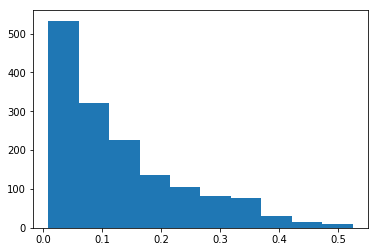

In [17]:
plt.hist(train_results['rsquared_array']) 
#uh oh - why are we so bad even on the training data?

In [18]:
#let's examine individual voxels
worst_vox = np.where(train_results['rsquared_array'] == np.amin(train_results['rsquared_array']))
print(worst_vox)
print(train_results['rsquared_array'][worst_vox])

best_vox = np.where(train_results['rsquared_array'] == np.amax(train_results['rsquared_array']))
print(best_vox)

(array([189]),)
[0.0088864]
(array([1473]),)


Text(0.5,1,'Predicted vs. actual response to images for the best voxel \nrval=0.524')

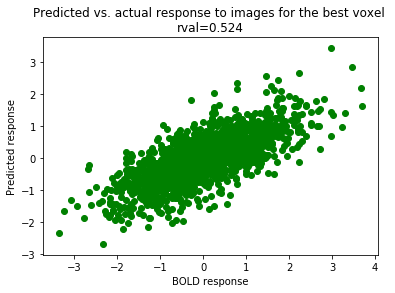

In [19]:
plt.scatter(S1_V4_train[:,best_vox],S1_pred_train_vox[:,best_vox], c='g')
plt.xlabel('BOLD response')
plt.ylabel('Predicted response')
plt.title('Predicted vs. actual response to images for the best voxel \nrval=%.3f'% train_results['rsquared_array'][best_vox])

Text(0.5,1,'Predicted vs. actual response to images for the worst voxel \nrval=0.009')

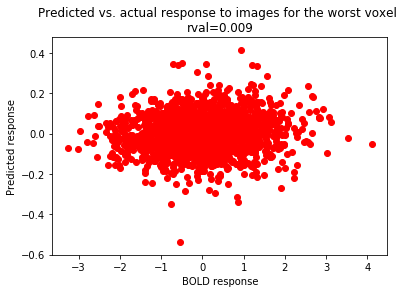

In [20]:
plt.scatter(S1_V4_train[:,worst_vox],S1_pred_train_vox[:,worst_vox],c='r')
plt.xlabel('BOLD response')
plt.ylabel('Predicted response')
plt.title('Predicted vs. actual response to images for the worst voxel \nrval=%.3f'% train_results['rsquared_array'][worst_vox])

In [21]:
S1_pred_train_vox.shape

(1750, 1535)

In [22]:
#let's try using ridge regression to fit individual voxels
#(cross-validate regularization params using RidgeCV)
vox_to_check = 500
rs = np.zeros(vox_to_check)
pred_val = np.zeros([120,vox_to_check])
train_val = np.zeros([1750,vox_to_check])
for vox in range(vox_to_check):
    clf = RidgeCV(alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1])
    clf.fit(train_feats, S1_V4_train[:,vox]) 
    
    train_val[:,vox] = clf.predict(train_feats)
    pred_val[:,vox] = clf.predict(val_feats)
    results = evaluate_regression_results(pred_val[:,vox],S1_V4_test[:,vox])
    
    rs[vox] = results['rsquared']

(array([396.,  41.,  29.,  13.,  10.,   2.,   3.,   3.,   1.,   2.]),
 array([8.61667936e-08, 2.37454267e-02, 4.74907672e-02, 7.12361077e-02,
        9.49814481e-02, 1.18726789e-01, 1.42472129e-01, 1.66217470e-01,
        1.89962810e-01, 2.13708151e-01, 2.37453491e-01]),
 <a list of 10 Patch objects>)

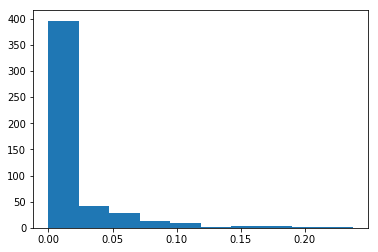

In [23]:
#okay what have we got
plt.hist(rs)

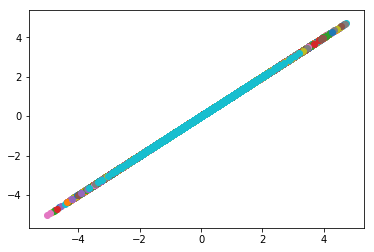

In [24]:
#how does it look for the training predictions
for vox in range(vox_to_check):
    plt.scatter(S1_V4_train[:,vox],train_val[:,vox])
    #hm okay guess we can get a perfect linear mapping for each vox cuz we have so many features?
    #overfitting...

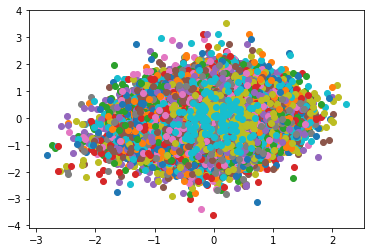

In [25]:
for vox in range(vox_to_check):
    plt.scatter(S1_V4_test[:,vox],pred_val[:,vox])

In [26]:
worst_vox = np.where(rs == np.amin(rs))
print(rs[worst_vox])

best_vox = np.where(rs == np.amax(rs))
print(rs[best_vox])

[8.61667936e-08]
[0.23745349]


Text(0.5,1,'Predicted vs. actual response to images \n Best voxel: rval=0.237')

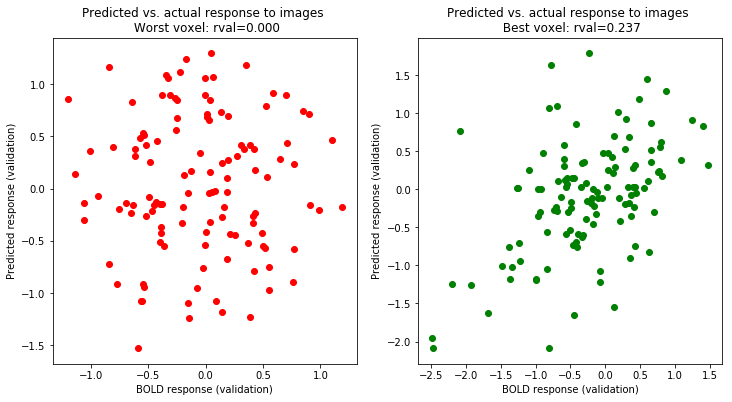

In [27]:
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(S1_V4_test[:,worst_vox],pred_val[:,worst_vox], c='r')
plt.xlabel('BOLD response (validation)')
plt.ylabel('Predicted response (validation)')
plt.title('Predicted vs. actual response to images \n Worst voxel: rval=%.3f'% rs[worst_vox])
plt.subplot(1, 2, 2)
plt.scatter(S1_V4_test[:,best_vox],pred_val[:,best_vox], c='g')
plt.xlabel('BOLD response (validation)')
plt.ylabel('Predicted response (validation)')
plt.title('Predicted vs. actual response to images \n Best voxel: rval=%.3f'% rs[best_vox])

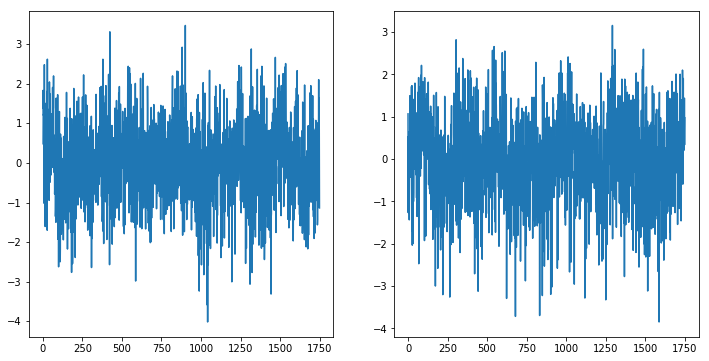

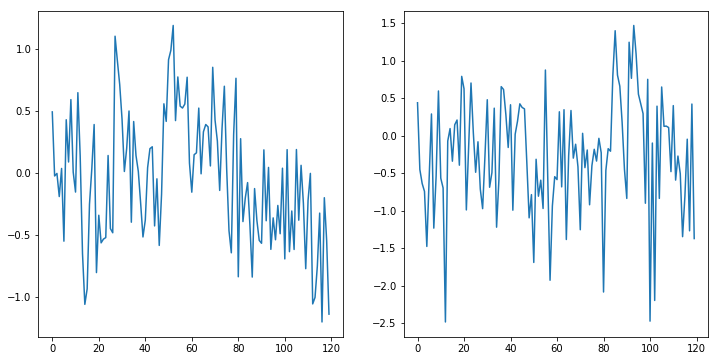

In [28]:
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(S1_V4_train[:,worst_vox[0]])
plt.subplot(1, 2, 2)
plt.plot(S1_V4_train[:,best_vox[0]])

fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(S1_V4_test[:,worst_vox[0]])
plt.subplot(1, 2, 2)
plt.plot(S1_V4_test[:,best_vox[0]])

## Try out regression models with proper train and test splits

In [29]:
## Alright this has not gone well
# let's start again with proper train and test splits within our training set
# (ignoring the validation data for now)

In [30]:
# create our own train test splits 
total_imgs = 1750
num_splits = 5
num_per_class_test=250
num_per_class_train=1500

#seed the random number generator
rng = np.random.RandomState(seed=0)

In [31]:
#construct the splits one by one
splits = []
for _split_ind in range(num_splits):
    
    #first construct the testing data
    actual_test_inds = []
    
    perm = rng.permutation(total_imgs)
    actual_test_inds = perm[ :num_per_class_test]
    
    actual_test_inds = np.sort(actual_test_inds)
    
    # then training
    remaining_available_train_inds = np.unique(list(set(
                       perm).difference(actual_test_inds)))
    actual_train_inds = np.sort(remaining_available_train_inds)

    split = {'train': actual_train_inds, 'test': actual_test_inds}
    splits.append(split)

In [34]:
resPLS = train_and_test_scikit_regressor(features=train_feats, 
                                labels=S1_V4_train,
                                splits=splits,
                                model_class=PLSRegression,
                                model_args={'n_components': 25,
                                            'scale': False})

In [35]:
print(resPLS['train']['mean_rsquared']) 
print(resPLS['test']['mean_rsquared']) #yikes we are not doing well

0.08577699208674307
0.0032967460812370506


In [36]:
resRidgeCV = train_and_test_scikit_regressor(features=train_feats, 
                                labels=S1_V4_train,
                                splits=splits,
                                model_class=RidgeCV,
                                model_args={'alphas':
                                            [1e-4, 1e-3, 1e-2, 1e-1, 1]})

In [37]:
print(resRidgeCV['train']['mean_rsquared']) 
print(resRidgeCV['test']['mean_rsquared']) 

0.9999999984553636
0.0026663251213200553


In [38]:
## let's subsample the features - should speed things up/maybe help with overfitting?
n = train_feats.shape[1]  
perm = rng.permutation(n)
#let's just keep 5000
keep_inds = perm[: 5000]
train_feats_sub = train_feats[:, keep_inds]
val_feats_sub = val_feats[:, keep_inds]

In [39]:
train_feats_sub.shape

(1750, 5000)

In [40]:
#okay gonna try Ridge again (that seemed to overfit like crazy the first time...)
resRidge_sub = train_and_test_scikit_regressor(features=train_feats_sub, 
                                labels=S1_V4_train,
                                splits=splits,
                                model_class=RidgeCV,
                                model_args={'alphas':
                                            [1e-4, 1e-3, 1e-2, 1e-1, 1]})

In [41]:
print(resRidge_sub['train']['mean_rsquared'])
print(resRidge_sub['test']['mean_rsquared']) #that still overfit training and failed test! ugh

0.9999967395887044
0.0022067092131015913


In [42]:
resPLS_sub = train_and_test_scikit_regressor(features=train_feats_sub, 
                                labels=S1_V4_train,
                                splits=splits,
                                model_class=PLSRegression,
                                model_args={'n_components': 50,
                                            'scale': False})

In [43]:
resPLS_sub['test']['mean_rsquared'] #well it didn't hurt

0.002814257771610069

In [46]:
#maybe I can use this to speed up fitting individual voxels with ridge
#(warning this takes absolutely forever even with the feature subsampling)
vox_to_check = 1535 #let's check them all
rs = np.zeros(vox_to_check)
test_rsquared=np.zeros([vox_to_check,1])

for vox in range(vox_to_check): 
    vox_res = train_and_test_scikit_regressor(features=train_feats_sub, 
                                labels=S1_V4_train[:,vox],
                                splits=splits,
                                model_class=RidgeCV,
                                model_args={'alphas':
                                            [1e-4, 1e-3, 1e-2, 1e-1, 1]})
    
    test_rsquared[vox,:]=vox_res['test']['mean_rsquared']


(array([1.446e+03, 6.200e+01, 1.900e+01, 5.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([2.46108943e-05, 1.38623618e-02, 2.77001127e-02, 4.15378636e-02,
        5.53756145e-02, 6.92133654e-02, 8.30511163e-02, 9.68888672e-02,
        1.10726618e-01, 1.24564369e-01, 1.38402120e-01]),
 <a list of 10 Patch objects>)

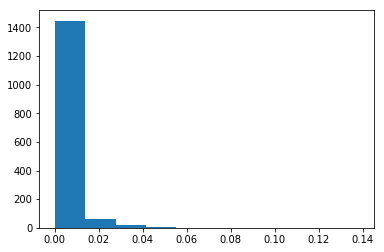

In [47]:
plt.hist(test_rsquared)

In [48]:
#is this consistently the same voxels that are fit well?
best_vox_inds = np.where(test_rsquared > .02)

In [49]:
best_vox_inds[0].shape

(43,)

In [57]:
np.where(test_rsquared > .025)

(array([  34,  104,  110,  121,  132,  153,  156,  273,  277,  278,  289,
         293,  303,  304,  319,  338,  349,  350,  351,  423,  503,  504,
         992, 1183, 1227, 1252, 1296, 1297, 1383, 1388, 1458]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [51]:
#check validation but only for these A+ (it's all relative) voxels

vox_to_check = best_vox_inds[0].shape[0]

best_rs = np.zeros(vox_to_check)
best_pred_val = np.zeros([120,vox_to_check])
best_train_val = np.zeros([1750,vox_to_check])

for idx in range(vox_to_check): 
    
    vox = best_vox_inds[0][idx]
    
    clf = RidgeCV(alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1])
    clf.fit(train_feats_sub, S1_V4_train[:,vox]) 
    
    best_train_val[:,idx] = clf.predict(train_feats_sub)
    best_pred_val[:,idx] = clf.predict(val_feats_sub)
    results = evaluate_regression_results(best_pred_val[:,idx],S1_V4_test[:,vox])
    
    best_rs[idx] = results['rsquared']
    

(array([14.,  5.,  6.,  3.,  5.,  2.,  2.,  0.,  4.,  2.]),
 array([5.40526357e-06, 9.59458653e-03, 1.91837678e-02, 2.87729490e-02,
        3.83621303e-02, 4.79513116e-02, 5.75404928e-02, 6.71296741e-02,
        7.67188554e-02, 8.63080366e-02, 9.58972179e-02]),
 <a list of 10 Patch objects>)

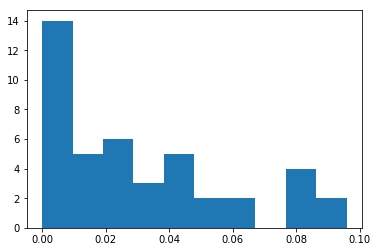

In [52]:
plt.hist(best_rs)

In [53]:
np.mean(best_rs)

0.030596602366515784

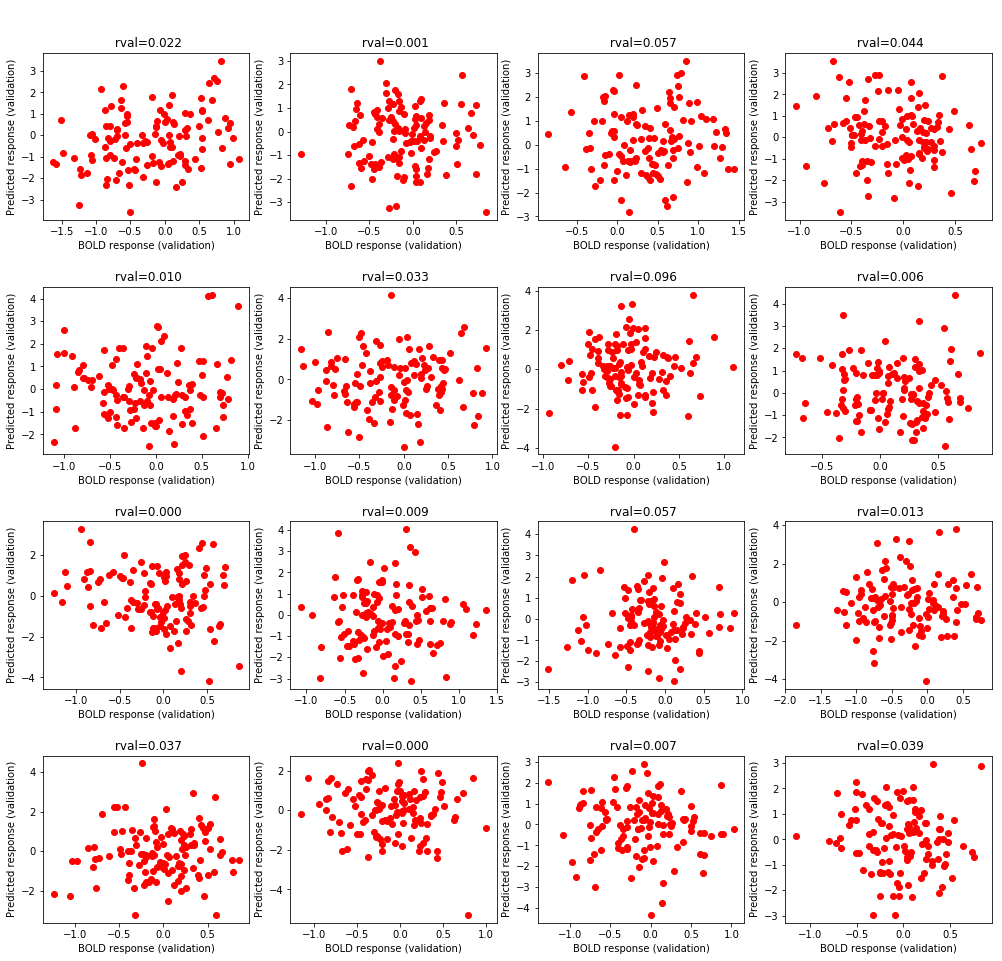

In [54]:
fig = plt.figure(figsize=(17, 16))

for i in range(16):
    ax=plt.subplot(4, 4, i+1)
    plt.subplots_adjust(hspace=0.4)
    plt.scatter(S1_V4_test[:,i],best_pred_val[:,i], c='r')
    plt.xlabel('BOLD response (validation)')
    plt.ylabel('Predicted response (validation)')
    ax.set_title('\n \n rval=%.3f'% best_rs[i])

0.9999999984553636
0.0026663251213200553


Text(0.5,1,'Distribution of voxel r-squared on validation data')

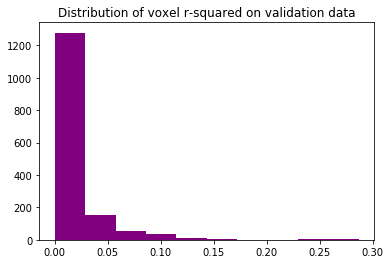

In [55]:
#let's do an overall evaluation
resRidge_sub = train_and_test_scikit_regressor(features=train_feats, 
                                labels=S1_V4_train,
                                splits=splits,
                                model_class=RidgeCV,
                                model_args={'alphas':
                                            [1e-4, 1e-3, 1e-2, 1e-1, 1]},
                                return_models=True)
print(resRidge_sub['train']['mean_rsquared']) 
print(resRidge_sub['test']['mean_rsquared']) 
#and on the validation data? (just picking the model from the first split)
S1_pred_val_resRidge = resRidge_sub['models'][0].predict(val_feats)
S1_pred_val_resRidge.shape
S1_val_results_ridge = evaluate_regression_results(S1_pred_val_resRidge,S1_V4_test)
plt.hist(S1_val_results_ridge['rsquared_array'], color='purple')
plt.title('Distribution of voxel r-squared on validation data')

0.07161125250673425
0.002912237908151272


Text(0.5,1,'Distribution of voxel r-squared on validation data')

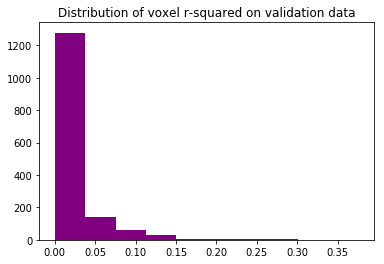

In [58]:
#compare this to 25dim PLS on subsamp'ed feats
resPLS_25 = train_and_test_scikit_regressor(features=train_feats_sub, 
                                labels=S1_V4_train,
                                splits=splits,
                                model_class=PLSRegression,
                                model_args={'n_components': 25,
                                            'scale': False},
                                return_models = True)
print(resPLS_25['train']['mean_rsquared']) 
print(resPLS_25['test']['mean_rsquared']) 
#and on the validation data? (just picking the model from the first split)
S1_pred_val_resPLS25 = resPLS_25['models'][0].predict(val_feats_sub)
S1_val_results_PLS25 = evaluate_regression_results(S1_pred_val_resPLS25,S1_V4_test)
plt.hist(S1_val_results_PLS25['rsquared_array'], color = 'purple')
plt.title('Distribution of voxel r-squared on validation data')

In [60]:
#summary stats
test_mean_ridge = np.mean(resRidge_sub['test']['by_split'][0]['rsquared_array'])
test_std_ridge = np.std(resRidge_sub['test']['by_split'][0]['rsquared_array'])

train_mean_ridge = np.mean(resRidge_sub['train']['by_split'][0]['rsquared_array'])
train_std_ridge = np.std(resRidge_sub['train']['by_split'][0]['rsquared_array'])

val_mean_ridge = np.mean(S1_val_results_ridge['rsquared_array'])
val_std_ridge = np.std(S1_val_results_ridge['rsquared_array'])

test_mean_PLS25 = np.mean(resPLS_25['test']['by_split'][0]['rsquared_array'])
test_std_PLS25 = np.std(resPLS_25['test']['by_split'][0]['rsquared_array'])

train_mean_PLS25 = np.mean(resPLS_25['train']['by_split'][0]['rsquared_array'])
train_std_PLS25 = np.std(resPLS_25['train']['by_split'][0]['rsquared_array'])

val_mean_PLS25 = np.mean(S1_val_results_PLS25['rsquared_array'])
val_std_PLS25 = np.std(S1_val_results_PLS25['rsquared_array'])

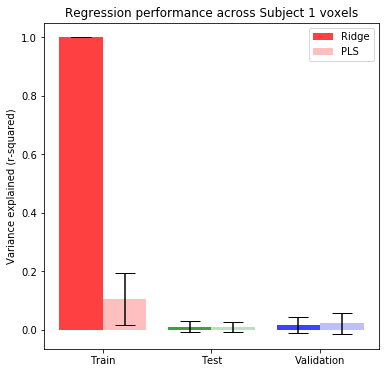

In [65]:
#plot
cats = ['Train', 'Test', 'Validation']
x_pos = np.arange(len(cats))
barWidth = .4
# Set position of bar on X axis
r1 = np.arange(len(cats))
r2 = [x + barWidth for x in r1]

Ridge_rs = [train_mean_ridge, test_mean_ridge,val_mean_ridge]
Ridge_error = [train_std_ridge, test_std_ridge, val_std_ridge]
PLS_rs = [train_mean_PLS25, test_mean_PLS25,val_mean_PLS25]
PLS_error = [train_std_PLS25, test_std_PLS25, val_std_PLS25]

fig = plt.figure(figsize=(6, 6))
plt.bar(r1, Ridge_rs, yerr=Ridge_error, width=barWidth, color=['red', 'green', 'blue'],\
       align='center', alpha=0.75, ecolor='black', capsize=10, label='Ridge')
plt.bar(r2, PLS_rs, yerr=PLS_error,  width=barWidth, color=['red', 'green', 'blue'],\
       align='center', alpha=0.25, ecolor='black', capsize=10, label='PLS')
plt.ylabel('Variance explained (r-squared)')
plt.xticks([r + barWidth/2 for r in range(len(cats))], cats)
plt.title('Regression performance across Subject 1 voxels')

plt.legend()
plt.show

plt.savefig('figs/S1_regs.png')

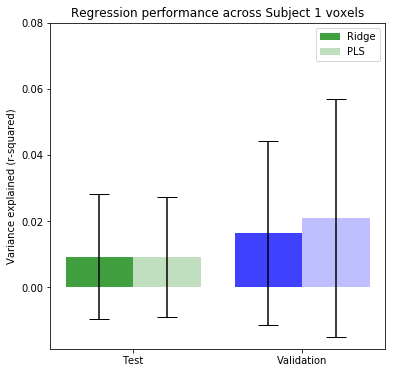

In [67]:
#something weird is going on with training
#let's get rid of it and cap ylim to match retinawarp

#plot
cats = ['Test', 'Validation']
x_pos = np.arange(len(cats))
barWidth = .4
# Set position of bar on X axis
r1 = np.arange(len(cats))
r2 = [x + barWidth for x in r1]

Ridge_rs = [test_mean_ridge,val_mean_ridge]
Ridge_error = [test_std_ridge, val_std_ridge]
PLS_rs = [test_mean_PLS25,val_mean_PLS25]
PLS_error = [test_std_PLS25, val_std_PLS25]

fig = plt.figure(figsize=(6, 6))
plt.bar(r1, Ridge_rs, yerr=Ridge_error, width=barWidth, color=['green', 'blue'],\
       align='center', alpha=0.75, ecolor='black', capsize=10, label='Ridge')
plt.bar(r2, PLS_rs, yerr=PLS_error,  width=barWidth, color=['green', 'blue'],\
       align='center', alpha=0.25, ecolor='black', capsize=10, label='PLS')
plt.ylabel('Variance explained (r-squared)')
plt.xticks([r + barWidth/2 for r in range(len(cats))], cats)
plt.title('Regression performance across Subject 1 voxels')
plt.ylim(top=0.06)

plt.legend()
plt.show

plt.savefig('figs/S1_regs_notrain.png')

## Regression testing - subject 2

In [68]:
## same thing but for subject 2

S2_resRidge_sub = train_and_test_scikit_regressor(features=train_feats, 
                                labels=S2_V4_train,
                                splits=splits,
                                model_class=RidgeCV,
                                model_args={'alphas':
                                            [1e-4, 1e-3, 1e-2, 1e-1, 1]},
                                return_models=True)
print(S2_resRidge_sub['train']['mean_rsquared']) 
print(S2_resRidge_sub['test']['mean_rsquared']) 


0.9999999984559163
0.002163816781087016


Text(0.5,1,'Distribution of voxel r-squared on validation data')

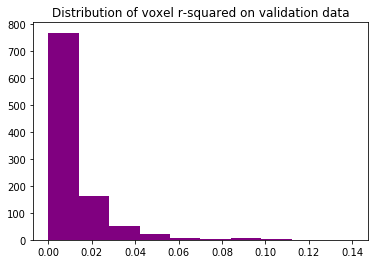

In [71]:
#and on the validation data? (just picking the model from the first split)
S2_pred_val_resRidge = S2_resRidge_sub['models'][0].predict(val_feats)
S2_val_results_ridge = evaluate_regression_results(S2_pred_val_resRidge,S2_V4_test)
plt.hist(S2_val_results_ridge['rsquared_array'], color='purple')
plt.title('Distribution of voxel r-squared on validation data')

0.08007472127689365
0.0020726397438821363


Text(0.5,1,'Distribution of voxel r-squared on validation data')

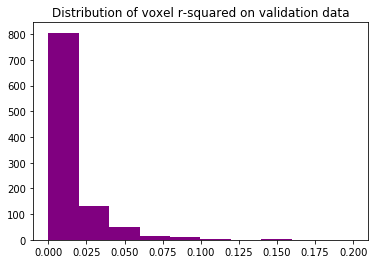

In [69]:
#compare this to 25dim PLS on subsamp'ed feats
S2_resPLS_25 = train_and_test_scikit_regressor(features=train_feats_sub, 
                                labels=S2_V4_train,
                                splits=splits,
                                model_class=PLSRegression,
                                model_args={'n_components': 25,
                                            'scale': False},
                                return_models = True)
print(S2_resPLS_25['train']['mean_rsquared']) 
print(S2_resPLS_25['test']['mean_rsquared']) 
#and on the validation data? (just picking the model from the first split)
S2_pred_val_resPLS25 = S2_resPLS_25['models'][0].predict(val_feats_sub)
S2_val_results_PLS25 = evaluate_regression_results(S2_pred_val_resPLS25,S2_V4_test)
plt.hist(S2_val_results_PLS25['rsquared_array'], color = 'purple')
plt.title('Distribution of voxel r-squared on validation data')

In [73]:
#summary stats
S2_test_mean_ridge = np.mean(S2_resRidge_sub['test']['by_split'][0]['rsquared_array'])
S2_test_std_ridge = np.std(S2_resRidge_sub['test']['by_split'][0]['rsquared_array'])

S2_train_mean_ridge = np.mean(S2_resRidge_sub['train']['by_split'][0]['rsquared_array'])
S2_train_std_ridge = np.std(S2_resRidge_sub['train']['by_split'][0]['rsquared_array'])

S2_val_mean_ridge = np.mean(S2_val_results_ridge['rsquared_array'])
S2_val_std_ridge = np.std(S2_val_results_ridge['rsquared_array'])

S2_test_mean_PLS25 = np.mean(S2_resPLS_25['test']['by_split'][0]['rsquared_array'])
S2_test_std_PLS25 = np.std(S2_resPLS_25['test']['by_split'][0]['rsquared_array'])

S2_train_mean_PLS25 = np.mean(S2_resPLS_25['train']['by_split'][0]['rsquared_array'])
S2_train_std_PLS25 = np.std(S2_resPLS_25['train']['by_split'][0]['rsquared_array'])

S2_val_mean_PLS25 = np.mean(S2_val_results_PLS25['rsquared_array'])
S2_val_std_PLS25 = np.std(S2_val_results_PLS25['rsquared_array'])

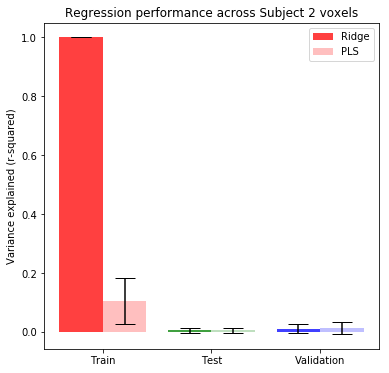

In [74]:
#plot
cats = ['Train', 'Test', 'Validation']
x_pos = np.arange(len(cats))
barWidth = .4
# Set position of bar on X axis
r1 = np.arange(len(cats))
r2 = [x + barWidth for x in r1]

S2_Ridge_rs = [S2_train_mean_ridge, S2_test_mean_ridge,S2_val_mean_ridge]
S2_Ridge_error = [S2_train_std_ridge, S2_test_std_ridge, S2_val_std_ridge]
S2_PLS_rs = [S2_train_mean_PLS25, S2_test_mean_PLS25,S2_val_mean_PLS25]
S2_PLS_error = [S2_train_std_PLS25, S2_test_std_PLS25, S2_val_std_PLS25]

#fig, ax = plt.subplots()
fig = plt.figure(figsize=(6, 6))
plt.bar(r1, S2_Ridge_rs, yerr=S2_Ridge_error, width=barWidth, color=['red', 'green', 'blue'],\
       align='center', alpha=0.75, ecolor='black', capsize=10, label='Ridge')
plt.bar(r2, S2_PLS_rs, yerr=S2_PLS_error,  width=barWidth, color=['red', 'green', 'blue'],\
       align='center', alpha=0.25, ecolor='black', capsize=10, label='PLS')
plt.ylabel('Variance explained (r-squared)')
plt.xticks([r + barWidth/2 for r in range(len(cats))], cats)
plt.title('Regression performance across Subject 2 voxels')

plt.legend()
plt.show

plt.savefig('figs/S2_regs.png')

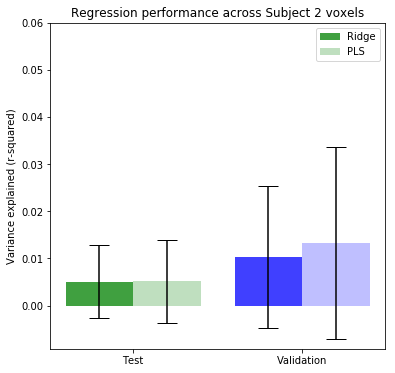

In [75]:
#plot test and val only for comparison
cats = ['Test', 'Validation']
x_pos = np.arange(len(cats))
barWidth = .4
# Set position of bar on X axis
r1 = np.arange(len(cats))
r2 = [x + barWidth for x in r1]

S2_Ridge_rs = [S2_test_mean_ridge,S2_val_mean_ridge]
S2_Ridge_error = [S2_test_std_ridge, S2_val_std_ridge]
S2_PLS_rs = [S2_test_mean_PLS25, S2_val_mean_PLS25]
S2_PLS_error = [S2_test_std_PLS25, S2_val_std_PLS25]

#fig, ax = plt.subplots()
fig = plt.figure(figsize=(6, 6))
plt.bar(r1, S2_Ridge_rs, yerr=S2_Ridge_error, width=barWidth, color=[ 'green', 'blue'],\
       align='center', alpha=0.75, ecolor='black', capsize=10, label='Ridge')
plt.bar(r2, S2_PLS_rs, yerr=S2_PLS_error,  width=barWidth, color=['green', 'blue'],\
       align='center', alpha=0.25, ecolor='black', capsize=10, label='PLS')
plt.ylabel('Variance explained (r-squared)')
plt.xticks([r + barWidth/2 for r in range(len(cats))], cats)
plt.title('Regression performance across Subject 2 voxels')
plt.ylim(top=.06)

plt.legend()
plt.show

plt.savefig('figs/S2_regs_notrain.png')

## V4 average

In [76]:
#what about if we just look at the population average instead of trying to fit each individual voxel?
#(testing on subject 1)

In [78]:
S1_V4_train.shape

(1750, 1535)

In [88]:
mean_S1_V4_train = np.mean(S1_V4_train,axis=1)
std_S1_V4_train = np.std(S1_V4_train,axis=1)

mean_S1_V4_test = np.mean(S1_V4_test,axis=1)
std_S1_V4_test = np.std(S1_V4_test,axis=1)

<function matplotlib.pyplot.show>

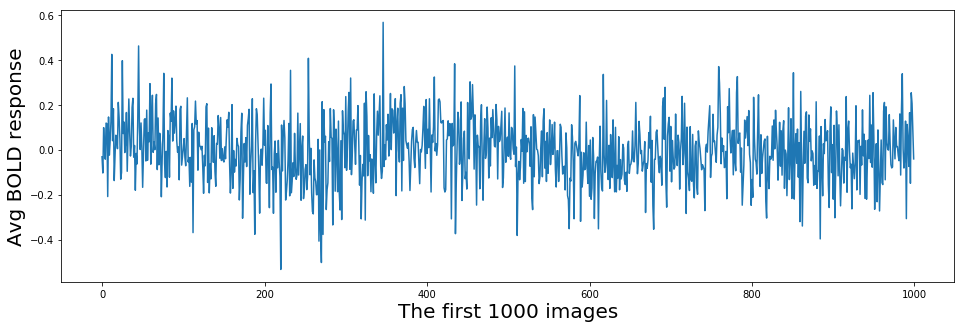

In [89]:
#plot average
N_images = 1000
plt.figure(figsize=(16,5))
plt.plot(mean_S1_V4_train[0:N_images]) #avg of all V4 voxels for 1st N images

plt.xlabel('The first %d images' % N_images, fontsize=20)
plt.ylabel('Avg BOLD response', fontsize=20)

plt.show

In [108]:
clf = PLSRegression(n_components=5) 
clf.fit(train_feats, mean_S1_V4_train) 

train_val = clf.predict(train_feats)
pred_val = clf.predict(val_feats)
train_results = evaluate_regression_results(train_val[:,0],mean_S1_V4_train)
results = evaluate_regression_results(pred_val[:,0],mean_S1_V4_test)
print(train_results['rsquared'])
print(results['rsquared'])
#overfits with more components... 

0.7700846495436425
0.0015261468530744248


In [116]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression().fit(train_feats, mean_S1_V4_train) 

lin_train_val = lin.predict(train_feats)
lin_pred_val = lin.predict(val_feats)
lin_train_results = evaluate_regression_results(lin_train_val,mean_S1_V4_train)
lin_results = evaluate_regression_results(lin_pred_val,mean_S1_V4_test)
print(lin_train_results['rsquared'])
print(lin_results['rsquared'])

0.999999999982333
0.0403305966999201


In [117]:
#back to PLS
clf = PLSRegression(n_components=1) 
clf.fit(train_feats, mean_S1_V4_train) 

train_val = clf.predict(train_feats)
pred_val = clf.predict(val_feats)
train_results = evaluate_regression_results(train_val[:,0],mean_S1_V4_train)
results = evaluate_regression_results(pred_val[:,0],mean_S1_V4_test)
print(train_results['rsquared'])
print(results['rsquared']) #yay!

0.10533943799294107
0.17663172942416877


In [115]:
lin_train_val.shape

(1750,)

In [96]:
mean_S1_V4_test.shape

(120,)

In [125]:
#subsample?
clf = PLSRegression(n_components=1) 
clf.fit(train_feats_sub, mean_S1_V4_train) 

train_val = clf.predict(train_feats_sub)
pred_val = clf.predict(val_feats_sub)
train_results = evaluate_regression_results(train_val[:,0],mean_S1_V4_train)
results = evaluate_regression_results(pred_val[:,0],mean_S1_V4_test)
print(train_results['rsquared'])
print(results['rsquared']) #yay!
#even better

0.09975913532225253
0.19693439414187763


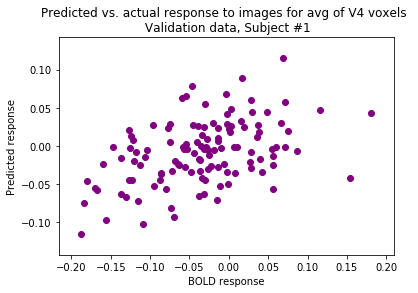

In [132]:
plt.scatter(mean_S1_V4_test,pred_val[:,0], c='purple')
plt.xlabel('BOLD response')
plt.ylabel('Predicted response')
plt.title('Predicted vs. actual response to images for avg of V4 voxels \n Validation data, Subject #1')
plt.savefig('figs/S1_V4avg.png')